# ARTEMIS emulator example 

***Note: If you are tunning this script first then the statisics will need to be retrained. This may take a few minutes. There will also be a few warniong meassges, this is perectly normal and nothing to worry about.***

In this example script we will go through the basic way to interact with the emulators to make predictions for a range of statistics. For simplicity we will mainly focus on studying the host stellar mass and satellite stellar mass function.
To start off let's load the modules we will need, and initialise the emulator class


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from Emulator_functions import emulator
from Emulator_functions import rescale

em = emulator()

## Host stellar mass

The very first thing we need to do is find the statistic that we want. This can be done with the `list_stats()` function.

In [2]:
stats_all = em.list_stats()
print(len(stats_all))

271


Here we see that there are 271 total statistics already with emulators built. We can search the full list of statistics by giving phrases to `list_stats()`. Here we are going to want the stellar mass within 30 kpc. So let's use the three phrases 'mass', '30' and '4' (for particle type 4, i.e. stars). Note that the search is case insensitive.

In [3]:
stat = em.list_stats(['mass','30','4'])
print(stat)

['ApertureMeasurements_Mass_030kpc_PartType4']


The statistic we want is then 'ApertureMeasurements_Mass_030kpc_PartType4'. We can start by looking at the description that is saved with the statisic.

In [4]:
em.get_description('ApertureMeasurements_Mass_030kpc_PartType4')

'Subhalo: ApertureMeasurements/Mass/030kpc/PartType4, log'

The output of the description if fairly formulaic. This is due to many of the statiscs for the host being automatically trained. Here the first part tells us that it is a subhalo property, then the path in the HDF5 subfind files is given. Finally, any extra information about how the data was processed is provided; here the data has been logged. The units for this will be the same as the subfind outputs.

Now we can now start to use the emulators to predict the host stellar mass as a function of the emulated parameters. Let's first set up a few variables that will be useful later on. First let's define the fiducial choice of parameters (used in the original ARTEMIS suite). In the emulator the parameters are, in order, the WDM mass, two of the three stellar feedback parameters, A, log f_max, the star formation threshold  log n_H, the final stellar feedback parameter log rho_H and the reionisation redshift.

In [5]:
fiducial=np.array([np.infty,0.1,np.log10(3),np.log10(0.1),np.log10(50),11.5]).reshape(1,-1)
fiducial_norm=rescale(fiducial,normalised=False)

label=['$m_{\\rm{WDM}}$','$A$','$f_{\\rm{max}}$','$n_H^*$','$\\rho_H$','$z_{\\rm{reion}}$']

Here we have the fiducial choice of parameters. Quoted in 'real' (`fiducial`) and emulator coordinates (`fiducial_norm`), that are normalised from 0 to 1 over the emulators range. Depending on the context it can be useful to work in either coordinate system, and all functions can work with either. The function rescale is useful to convert between the two. Here the kwarg `normalised=False` specifies that the input array is not normalised and will convert to emulator coordinated. Setting `normalised=True` would convert out of emulator coordinates to real coordinates.

Let's start by seeing what the prediction for the stellar mass is for the fiducial choice of parameters.

In [6]:
stel_mas , z = em.predict('ApertureMeasurements_Mass_030kpc_PartType4',fiducial,0.0,normalised=False)
print(stel_mas)

Sampling redshift 0.00
0.2846000262323414


Here the `predict` function is used to interface with the emulator for all of the trained statistics. It needs to be given the statistic’s name, the choice of parameters and the redshift range to sample (here we just want z=0). We have additionally specified that the input parameters are not in emulator coordinates (the default is to assume normalised, emulator coordinates). Also, be careful with the shape of the input array, it must always be (N,6), even if N=1. By default the emulator returns the prediction for the statistic, and the redshifts sampled.

Here the output says that the stellar mass is -0.86, which at first doesn't seem right. However, remember that this is the logged stellar mass, in the base units output by SUBFIND (which is 10^10 M_sun/h). Hence the mass  is 10^(0.3+10) ~ 2 * 10^10 M_sun /h.

We can now explore how sensitive the host stellar mass is to each parameter.

Statistic already loaded
Sampling redshift 0.00
Statistic already loaded
Sampling redshift 0.00
Statistic already loaded
Sampling redshift 0.00
Statistic already loaded
Sampling redshift 0.00
Statistic already loaded
Sampling redshift 0.00
Statistic already loaded
Sampling redshift 0.00


Text(0, 0.5, '$M_{*}$ [$h^{-1}$M$_{\\odot}$]')

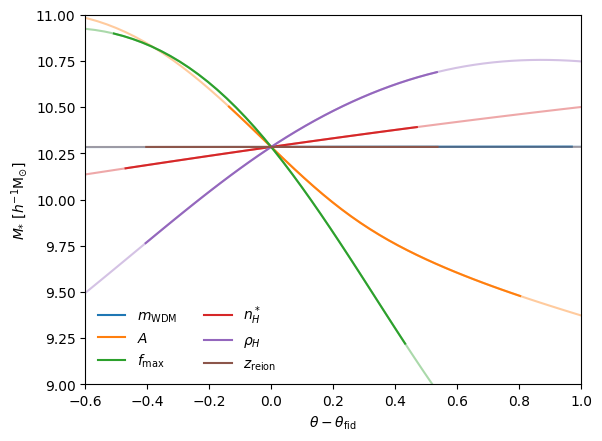

In [7]:
x_sample=np.linspace(-1,2,100)
stellar_mass=[]
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i in range(6):
    
    theta=np.repeat(fiducial_norm,len(x_sample),axis=0)
    theta[:,i]=x_sample
    
    #here we used normalised emulator coordinates
    y,_ = em.predict('ApertureMeasurements_Mass_030kpc_PartType4',theta,0.0) 
    
    stellar_mass.append(y+10.0) #+10 as subfind works in 10^10 M_sun
    
#plot data
fig=plt.figure()
for i in range(6):
    cut = (x_sample>0) & (x_sample<1)
    plt.plot(x_sample[cut]-fiducial_norm[0,i],stellar_mass[i][cut],label=label[i],color=colors[i])
    plt.plot(x_sample-fiducial_norm[0,i],stellar_mass[i],alpha=0.4,color=colors[i])


plt.xlim(-0.6,1.0)
plt.ylim(9.0,11)
plt.legend(frameon=False,ncol=2)
plt.xlabel('$\\theta-\\theta_{\\rm{fid}}$')
plt.ylabel('$M_{*}$ [$h^{-1}$M$_{\\odot}$]')

First we notice that the call to the predict function is giving us a warning that some of the predictions are outside the emulator's range. This is taken into account when plotting where we plot the lines transparent outside the emulator range. Remember in emulator coordinates the emulator's range is (0,1) in each axis.

Here we can see that the dominant parameters for the stellar mass are A, f_max and rho_H, the three stellar feedback parameters. The WDM mass and reionisation redshift don't matter at all, while the stellar mass is mildly sensitive to star formation threshold n_H.

We can also see how the stellar mass varies as a function of redshift. Lets look from z=0 to 3.

Statistic already loaded
Sampling between redshift 0.00 and 2.48


Text(0, 0.5, '$M_{*}$ [$h^{-1}$M$_{\\odot}$]')

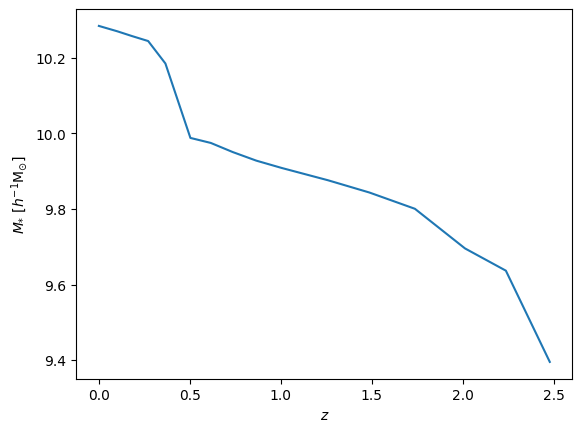

In [8]:
stel_mas , z = em.predict('ApertureMeasurements_Mass_030kpc_PartType4',fiducial,[0.0,3.0],normalised=False)
    
plt.figure()
plt.plot(z,stel_mas+10)
plt.xlabel('$z$')
plt.ylabel('$M_{*}$ [$h^{-1}$M$_{\\odot}$]')

## Satellite stellar mass function

We can also look at statistics that aren't a single summary value for the host. Let's now look at the satellite populations and how they vary as a function of the most important parameters. Starting with the fiducial combination.

Let's first look at the statistic description.

In [9]:
em.get_description('Sat_stellar_mass_func')

'Cumulative satellite stellar mass function, using subfind bound stellar mass and all satellite within FOF group'

The description here is less formualic than above, indicating it is a statisic trained 'by hand'. From the descripton we get what the staticst is, i.e. the cumulative stellar mass funciton of satellites, along with a bit of information about how the statistic was calculated.

Sampling redshift 0.00


Text(0, 0.5, '$N(>M_{stel})$')

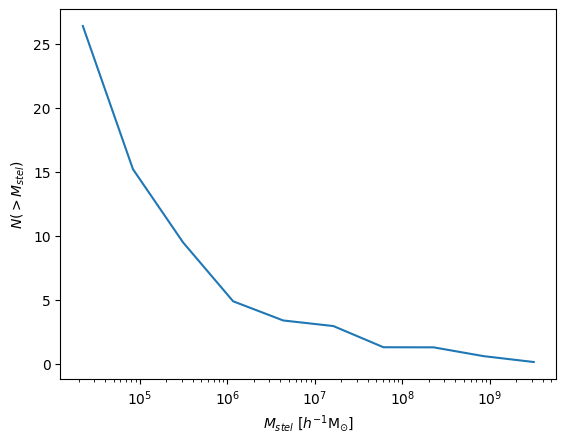

In [10]:
sat_count, z , m_bins = em.predict('Sat_stellar_mass_func',fiducial,0.0,return_x=True,normalised=False)

plt.figure()
plt.plot(m_bins,sat_count)
plt.xscale('log')
plt.xlabel('$M_{stel}$ $[h^{-1}$M$_{\\odot}]$')
plt.ylabel('$N(>M_{stel})$')

Here we have used the `return_x` flag to specify if the function should return any 'x' data that was specified when training the emulator As this is not used to train the emulator there are no rules for what this should, or could, be, so the context of the given statistic is important. Here the 'x' data is the mass bins used when calculating the cumulative stellar mass function.

We can also llok at how the stellar mass fuction varies as a function of some of the parameters. Let's focus on the WDM mass, reionaistion redshift and stellar feedback.

Statistic already loaded
Sampling redshift 0.00
Statistic already loaded
Sampling redshift 0.00
Statistic already loaded
Sampling redshift 0.00


Text(0, 0.5, '$N(>M_{stel})$')

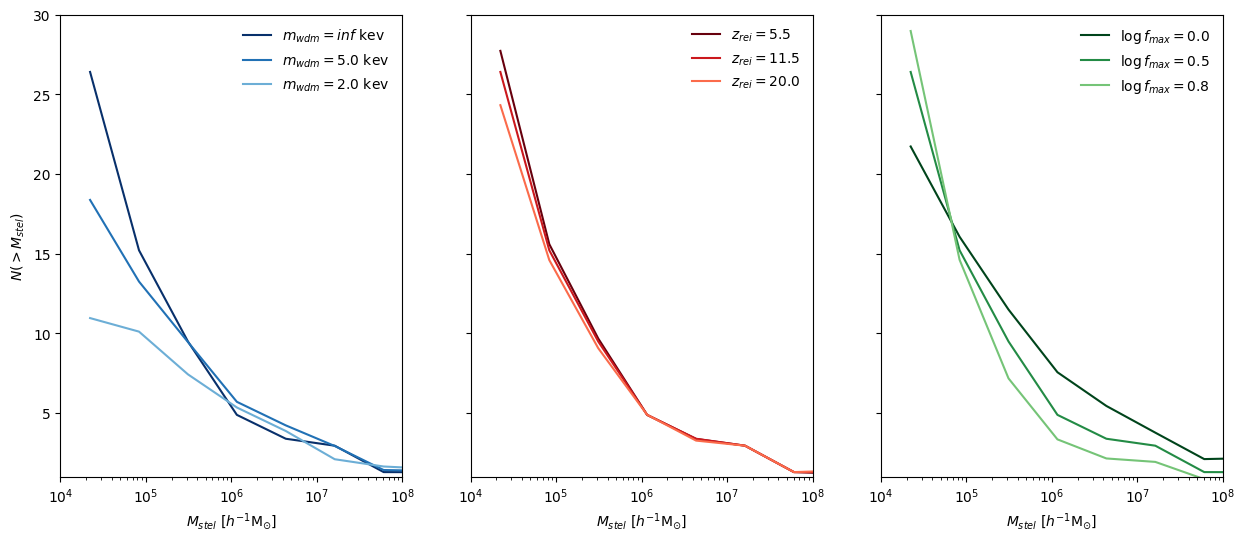

In [11]:
m_wdm = np.array([np.infty,5.0,2.0])
z_rei = np.array([5.5,11.5,20.0])

#for stellar feedback let's pick a stong, fiducial and weak feedback, THis can be done with f_max
f_max = np.array([np.log10(1),np.log10(3),np.log10(6)])

params = np.repeat(fiducial,3,axis=0)

param_copy = np.array(params)
param_copy[:,0] = m_wdm
sat_count_wdm,_ = em.predict('Sat_stellar_mass_func',param_copy,0.0,normalised=False)

param_copy = np.array(params)
param_copy[:,5] = z_rei
sat_count_rei,_ = em.predict('Sat_stellar_mass_func',param_copy,0.0,normalised=False)

param_copy = np.array(params)
param_copy[:,2] = f_max
sat_count_fmax,_ = em.predict('Sat_stellar_mass_func',param_copy,0.0,normalised=False)

#set up plotting axes
f, ax = plt.subplots(1, 3, sharey=True,figsize=(15,6))
cmaps = [matplotlib.cm.get_cmap('Blues_r'),matplotlib.cm.get_cmap('Reds_r'),matplotlib.cm.get_cmap('Greens_r')]

for i in range(3):
    ax[0].plot(m_bins,sat_count_wdm[i,:],color=cmaps[0]((i)/4),label='$m_{wdm} = %.1f$ kev'%m_wdm[i])
    ax[1].plot(m_bins,sat_count_rei[i,:],color=cmaps[1]((i)/4),label='$z_{rei} = %.1f$'%z_rei[i])
    ax[2].plot(m_bins,sat_count_fmax[i,:],color=cmaps[2]((i)/4),label='$\\log f_{max} = %.1f$'%f_max[i])
    
for i in range(3):
    ax[i].set_xscale('log')
    ax[i].set_xlim(10**4.0,10**8)
    ax[i].set_ylim(1.0,30)
    ax[i].set_xlabel('$M_{stel}$ $[h^{-1}$M$_{\\odot}]$')
    ax[i].legend(frameon=False)
ax[0].set_ylabel('$N(>M_{stel})$')

    

Here we see that all three of these parameters have an effect on the number of luminous satellites. However, the effect of the change is different. The WDM mass suppresses the number of satellites at small masses, with a lighter particle having more of an effect. Changing the reionisation redshift has a similar effect, but the magnitude of the difference is much smaller. On the other hand the form of the effect due to changing  the stellar feedback is quite different, and generally changes the whole stellar mass function.

## Conclusion

This covers the basic functionality of the code, from which you should be able to explore all of the trained statistics that are of interest and how they vary as a function of the emulator. Included in the examples folder are two additional scripts that show how to perform a mcmc analysis with the emulators. As well as a script on how to add additional statistics to the emulator, processing the simulations according to your particular scientific interests and needs.